# Chapter 4 - ARMA and ARIMA Modeling and Forecasting

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from PythonTsa.datadir import getdtapath
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

#### Use the function sm.tsa.arma_order_select_ic to determine order (p, q) to build the model ARMA(p, q) for the time series data NAO in Example 4.1. Then estimate the model ARMA(p, q) where (p, q) ∕= (1, 0) and explain it.

In [6]:
# Dataset

dtapath=getdtapath()

nao =pd.read_csv(dtapath + 'nao.csv', header = 0)

nao

,year,month,index
0,1950,1,0.92000
1,1950,2,0.40000
2,1950,3,-0.36000
3,1950,4,0.73000
4,1950,5,-0.59000
...,...,...,...
826,2018,11,-0.11126
827,2018,12,0.61156
828,2019,1,0.59202
829,2019,2,0.29141


In [7]:
timeindex = pd.date_range('1950-01', periods = len(nao), freq='ME')

nao.index = timeindex

nao

,year,month,index
1950-01-31,1950,1,0.92000
1950-02-28,1950,2,0.40000
1950-03-31,1950,3,-0.36000
1950-04-30,1950,4,0.73000
1950-05-31,1950,5,-0.59000
...,...,...,...
2018-11-30,2018,11,-0.11126
2018-12-31,2018,12,0.61156
2019-01-31,2019,1,0.59202
2019-02-28,2019,2,0.29141


In [8]:
naots = nao['index']

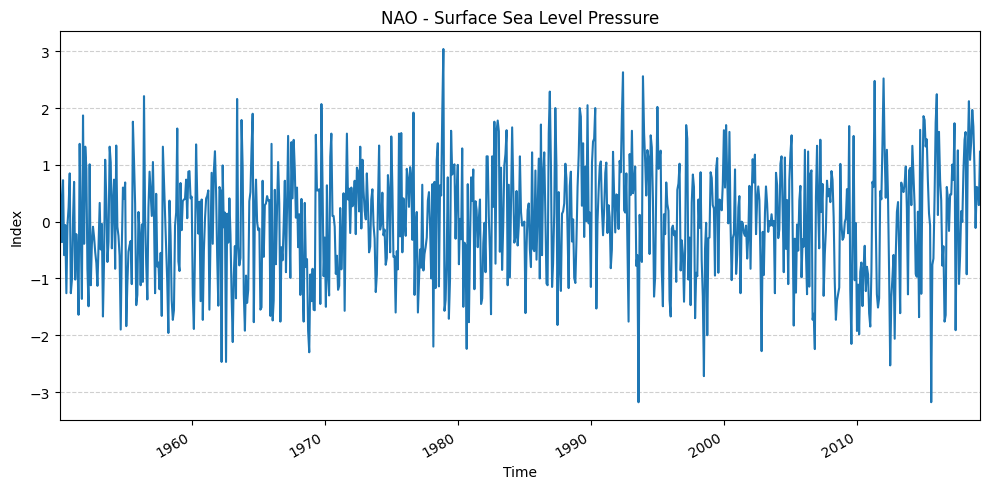

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(naots)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('NAO - Surface Sea Level Pressure')
ax.set_xlim(pd.to_datetime('1950-01-31'), pd.to_datetime('2019-03-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(naots)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -23.4946884465307
      p-value: 0.0

p-value < alpha; Ha: Stationary


In [11]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_stat, p_value, lags, critical_values = kpss(naots, regression='c', nlags=50)

# Output the results
print(f"KPSS Test Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical values: {critical_values}")
print()

# Interpretation
if p_value < 0.05:
    print("p-value < 0.05; Ha: series is Non-stationary")
else:
    print("p-value > 0.05; H0: series is Stationary")

KPSS Test Statistic: 0.3561836394749189
P-value: 0.09604153470908669
Lags used: 50
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

p-value > 0.05; H0: series is Stationary


#### Recommendation:
    If you are testing for stationarity around a constant mean (i.e., level-stationarity), use regression='c'.
    If you are testing for stationarity around a deterministic trend, use regression='ct'.

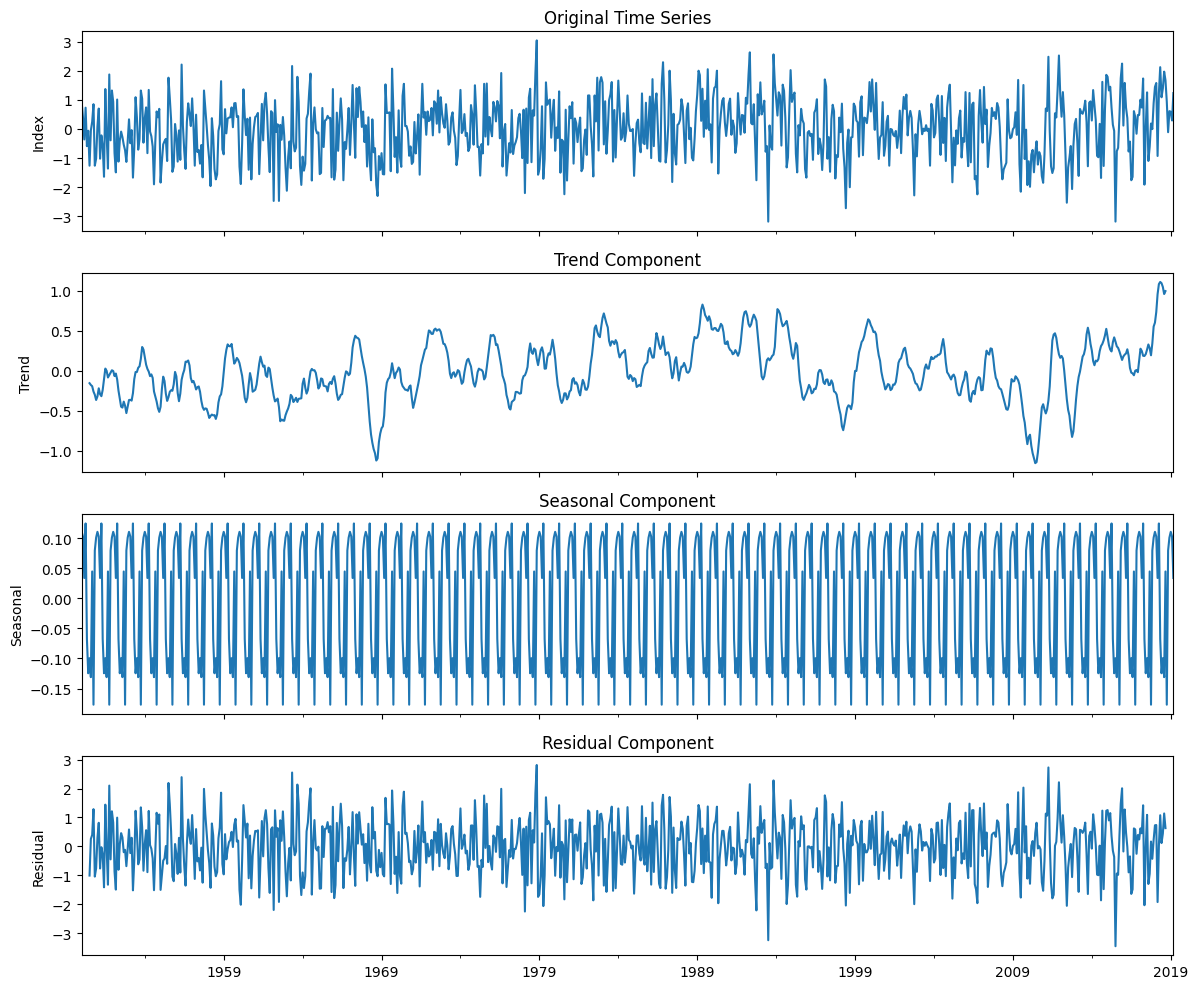

In [13]:
# Perform seasonal decomposition
nao_decom = seasonal_decompose(naots, model='aditive')  # quarterly data, so period = 4

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

nao_decom.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Index')

nao_decom.trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

nao_decom.seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

nao_decom.resid.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

#### Important:

    Use trend='c' when you believe your data has a non-zero mean, and you want the ARMA model to account for that baseline value.
    Use trend='n' when you believe your data has a zero mean or if you're modeling data where a constant intercept is not needed.

Despite there is a seasonal component, let's use a simple model as the statement of the question.

In [16]:
# Split the data into training and test sets (80% for training, 20% for testing)
train_size = int(len(naots) * 0.8)
train_data, test_data = naots[:train_size], naots[train_size:]

In [17]:
# Choosing p & q based on AIC
order_selection = sm.tsa.arma_order_select_ic(train_data, max_ar=4, max_ma=4, ic='aic', trend='c')

# Extract the AIC matrix from the result
aic_matrix = order_selection['aic']

# Create a list of (p, q) pairs and their corresponding AIC values
aic_list = []
for p in range(aic_matrix.shape[0]):
    for q in range(aic_matrix.shape[1]):
        aic_list.append(((p, q), aic_matrix.iloc[p, q]))

# Convert to DataFrame
aic_df = pd.DataFrame(aic_list, columns=['(p, q)', 'AIC'])

# Sort the DataFrame by AIC values in ascending order
aic_df_sorted = aic_df.sort_values(by='AIC').reset_index(drop=True)

# Display the sorted DataFrame
aic_df_sorted.head(10)

,"(p, q)",AIC
0,"(4, 4)",1854.523030
1,"(3, 3)",1855.228798
2,"(1, 3)",1855.346463
3,"(4, 3)",1855.846660
4,"(1, 0)",1856.342921
5,"(0, 1)",1856.549186
6,"(1, 4)",1856.749241
7,"(4, 1)",1856.866692
8,"(2, 0)",1858.342075
9,"(1, 1)",1858.342115


In [18]:
# Fit the ARIMA (1,0,0) model to our data
ar1 = ARIMA(train_data, order=(1,0,0), trend='n').fit()

# Display the summary
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  index   No. Observations:                  664
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -925.173
Date:                Fri, 07 Mar 2025   AIC                           1854.347
Time:                        08:23:02   BIC                           1863.343
Sample:                    01-31-1950   HQIC                          1857.833
                         - 04-30-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1389      0.037      3.760      0.000       0.066       0.211
sigma2         0.9500      0.057     16.716      0.000       0.839       1.061
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.52
Prob(Q):                              1.00   Prob(JB):                         0.17
Heteroskedasticity (H):               0.93   Skew:                            -0.08
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

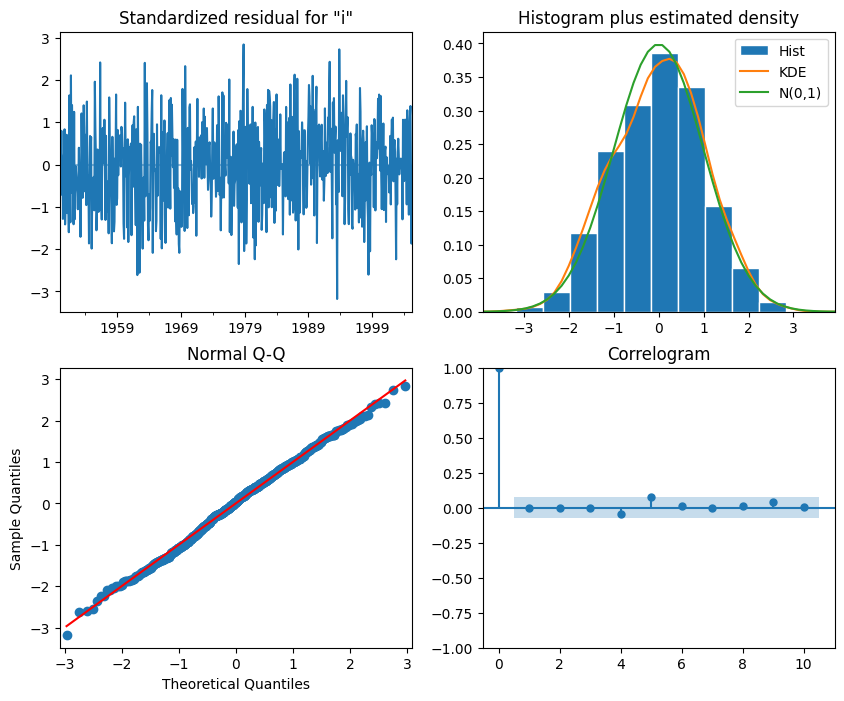

In [19]:
# Extract the residuals (errors) from the fitted model
residuals1 = ar1.resid 

# Diagnostic plots for the model, including residuals and other model checks
ar1.plot_diagnostics(figsize=(10,8));

In [20]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals1 = acorr_ljungbox(residuals1, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals1['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals1

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.000021,0.996367
2,0.000332,0.999834
3,0.000931,0.999992
4,1.267388,0.866884
5,5.184849,0.393740
6,5.341696,0.500792
7,5.342256,0.618273
8,5.452237,0.708326
9,6.761241,0.661962
10,6.797177,0.744444


Testing with the best p & q set:

In [22]:
# Fit the ARIMA (4,0,4) model to our data
ar2 = ARIMA(train_data, order=(4,0,4), trend='n').fit()

# Display the summary
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  index   No. Observations:                  664
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -917.292
Date:                Fri, 07 Mar 2025   AIC                           1852.584
Time:                        08:23:06   BIC                           1893.068
Sample:                    01-31-1950   HQIC                          1868.272
                         - 04-30-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1162      0.136     -0.855      0.393      -0.383       0.150
ar.L2          0.1665      0.134      1.239      0.215      -0.097       0.430
ar.L3          0.2403      0.125      1.923      0.054      -0.005       0.485
ar.L4          0.6807      0.121      5.612      0.000       0.443       0.918
ma.L1          0.2362      0.123      1.926      0.054      -0.004       0.476
ma.L2         -0.1371      0.121     -1.133      0.257      -0.374       0.100
ma.L3         -0.2609      0.115     -2.264      0.024      -0.487      -0.035
ma.L4         -0.7734      0.108     -7.194      0.000      -0.984      -0.563
sigma2         0.9276      0.056     16.501      0.000       0.817       1.038
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 3.62
Prob(Q):                              0.54   Prob(JB):                         0.16
Heteroskedasticity (H):               0.95   Skew:                            -0.07
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

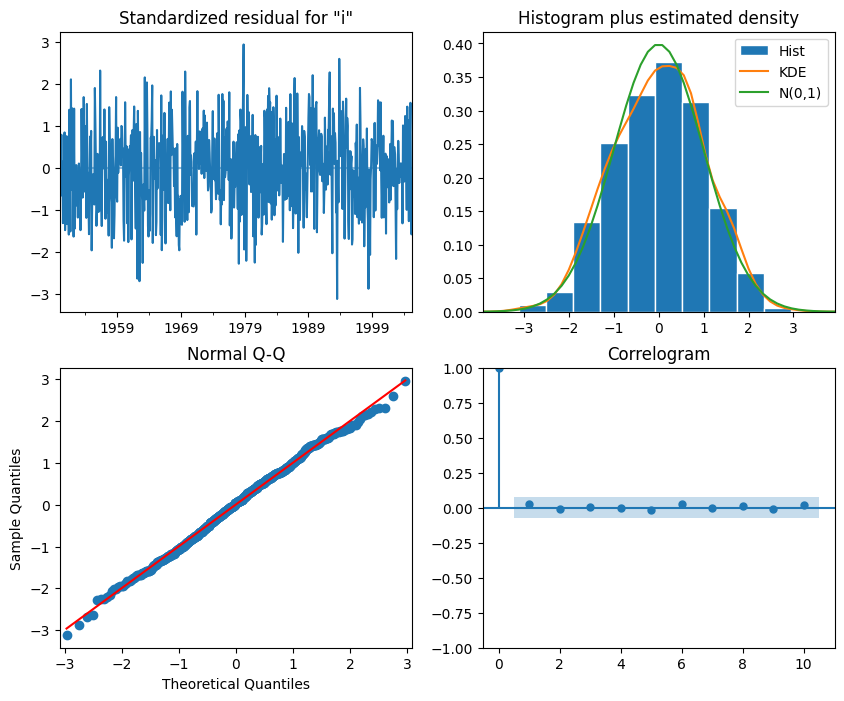

In [23]:
# Extract the residuals (errors) from the fitted model
residuals2 = ar2.resid 

# Diagnostic plots for the model, including residuals and other model checks
ar2.plot_diagnostics(figsize=(10,8));

In [24]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals2 = acorr_ljungbox(residuals2, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals2['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals2

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.378558,0.538376
2,0.415375,0.812461
3,0.431308,0.933702
4,0.436736,0.979360
5,0.575807,0.989084
6,1.010669,0.985205
7,1.010867,0.994651
8,1.178027,0.996854
9,1.267628,0.998532
10,1.528409,0.998844


In [25]:
# Split the data into training and test sets (80% for training, 20% for testing)
train_size = int(len(naots) * 0.8)
train_data, test_data = naots[:train_size], naots[train_size:]

print(len(train_data))
print(len(test_data))

664
167


In [26]:
# Construction of 'test_zone'

# Create an empty dataframe
test_zone = pd.DataFrame()

# Original Data created based on the end of the original dataset
test_zone['original data'] = naots.iloc[-167:]

test_zone.head()

,original data
2005-05-31,-1.25
2005-06-30,-0.05
2005-07-31,-0.51
2005-08-31,0.37
2005-09-30,0.63


In [27]:
# Forecast for different models
forecast_100 = ar1.forecast(steps=167) 
forecast_404 = ar2.forecast(steps=167) 

test_zone['forecast_100'] = forecast_100
test_zone['forecast_404'] = forecast_404

test_zone['difference_100'] = test_zone['forecast_100'] - test_zone['original data']
test_zone['difference_404'] = test_zone['forecast_404'] - test_zone['original data']

mean100 = test_zone['difference_100'].mean()
mean404 = test_zone['difference_404'].mean()

test_zone['correction100'] = test_zone['forecast_100'] + mean100
test_zone['correction404'] = test_zone['forecast_404'] + mean100

test_zone

,original data,forecast_100,forecast_404,difference_100,difference_404,correction100,correction404
2005-05-31,-1.25000,-4.166646e-02,-0.189998,1.208334,1.060002,-0.048353,-0.196684
2005-06-30,-0.05000,-5.786980e-03,0.261039,0.044213,0.311039,-0.012474,0.254352
2005-07-31,-0.51000,-8.037432e-04,-0.099757,0.509196,0.410243,-0.007490,-0.106443
2005-08-31,0.37000,-1.116304e-04,0.118530,-0.370112,-0.251470,-0.006798,0.111843
2005-09-30,0.63000,-1.550415e-05,-0.096969,-0.630016,-0.726969,-0.006702,-0.103656
...,...,...,...,...,...,...,...
2018-11-30,-0.11126,-5.389801e-141,0.009411,0.111260,0.120671,-0.006687,0.002725
2018-12-31,0.61156,-7.485798e-142,0.009339,-0.611560,-0.602221,-0.006687,0.002652
2019-01-31,0.59202,-1.039689e-142,0.009267,-0.592020,-0.582753,-0.006687,0.002580
2019-02-28,0.29141,-1.444005e-143,0.009196,-0.291410,-0.282214,-0.006687,0.002509


In [28]:
predictions1 = ar1.get_prediction(start='2005-05-31', end = '2019-03-31').predicted_mean
predictions2 = ar2.get_prediction(start='2005-05-31', end = '2019-03-31').predicted_mean

test_zone['pred_100'] = predictions1
test_zone['pred_404'] = predictions2

test_zone

,original data,forecast_100,forecast_404,difference_100,difference_404,correction100,correction404,pred_100,pred_404
2005-05-31,-1.25000,-4.166646e-02,-0.189998,1.208334,1.060002,-0.048353,-0.196684,-4.166646e-02,-0.189998
2005-06-30,-0.05000,-5.786980e-03,0.261039,0.044213,0.311039,-0.012474,0.254352,-5.786980e-03,0.261039
2005-07-31,-0.51000,-8.037432e-04,-0.099757,0.509196,0.410243,-0.007490,-0.106443,-8.037432e-04,-0.099757
2005-08-31,0.37000,-1.116304e-04,0.118530,-0.370112,-0.251470,-0.006798,0.111843,-1.116304e-04,0.118530
2005-09-30,0.63000,-1.550415e-05,-0.096969,-0.630016,-0.726969,-0.006702,-0.103656,-1.550415e-05,-0.096969
...,...,...,...,...,...,...,...,...,...
2018-11-30,-0.11126,-5.389801e-141,0.009411,0.111260,0.120671,-0.006687,0.002725,-5.389801e-141,0.009411
2018-12-31,0.61156,-7.485798e-142,0.009339,-0.611560,-0.602221,-0.006687,0.002652,-7.485798e-142,0.009339
2019-01-31,0.59202,-1.039689e-142,0.009267,-0.592020,-0.582753,-0.006687,0.002580,-1.039689e-142,0.009267
2019-02-28,0.29141,-1.444005e-143,0.009196,-0.291410,-0.282214,-0.006687,0.002509,-1.444005e-143,0.009196


In [29]:
# Choosing p & q
sm.tsa.arma_order_select_ic(train_data, max_ar=4, max_ma=4, ic='aic', trend='n')

{'aic':              0            1            2            3            4
 0  1865.279146  1854.553200  1856.354294  1858.294829  1858.392929
 1  1854.346727  1856.346130  1858.344701  1853.349036  1854.752050
 2  1856.345895  1858.345985  1858.987595  1856.414001  1857.717798
 3  1858.337796  1860.345354  1857.336420  1853.232013  1856.682932
 4  1859.657669  1854.869567  1858.099492  1853.849503  1852.583950,
 'aic_min_order': (4, 4)}

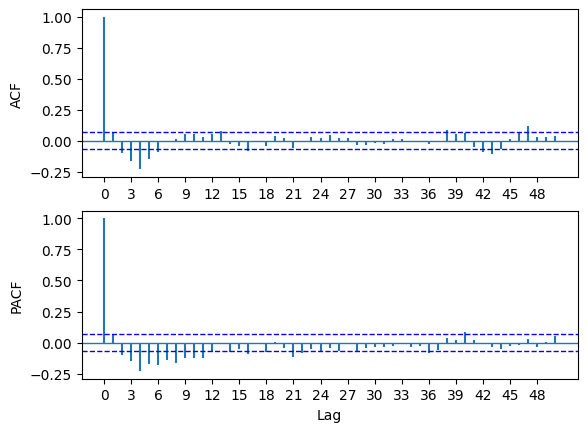

In [30]:
# Drop NA values from the residuals of the 'nao_decom' decomposition result
nao_decom_resid = nao_decom.resid.dropna() 

# Plot both ACF and PACF
acf_pacf_fig(nao_decom_resid, both=True, lag=50)

In [31]:
# Fit the ARIMA(1,0,0) model (model ar1)
ar1 = sm.tsa.ARIMA(train_data, order=(1, 0, 0)).fit()

# Fit the ARIMA(4,0,4) model (model ar2)
ar2 = sm.tsa.ARIMA(train_data, order=(4, 0, 4)).fit()

# Forecast the test period with both models
forecast_ar1 = ar1.forecast(steps=167)
forecast_ar2 = ar2.forecast(steps=167)

# Calculate the Mean Absolute Error (MAE) for both models
mae_ar1 = mean_absolute_error(test_data, forecast_ar1)
mae_ar2 = mean_absolute_error(test_data, forecast_ar2)

# Calculate the Mean Squared Error (MSE) for both models
mse_ar1 = mean_squared_error(test_data, forecast_ar1)
mse_ar2 = mean_squared_error(test_data, forecast_ar2)

# Print the results
print(f"ARIMA(1,0,0) Model (ar1) - MAE: {mae_ar1:.4f}, MSE: {mse_ar1:.4f}")
print(f"ARIMA(4,0,4) Model (ar2) - MAE: {mae_ar2:.4f}, MSE: {mse_ar2:.4f}")
print()

ARIMA(1,0,0) Model (ar1) - MAE: 0.9488, MSE: 1.2908
ARIMA(4,0,4) Model (ar2) - MAE: 0.9515, MSE: 1.2969



#### For the simulated time series sample in Example 4.2, we observe that its PACF shown in Fig. 4.7 seems to cut off after lag 3. As a result, an ARMA(3,0) model could be used to fit the sample. Please build this model and compare it with the fitted model in Example 4.2.

In [33]:
# Set the random seed for reproducibility
np.random.seed(42) 

# Define the AR and MA coefficients
ar = np.array([1, -0.8 , 0.6])  # AR(2) coefficients
ma = np.array([1, 0.7, 0.4])    # MA(2) coefficients

# Generate the sample time series using ARMA
x = arma_generate_sample(ar=ar, ma =ma, nsample=500)

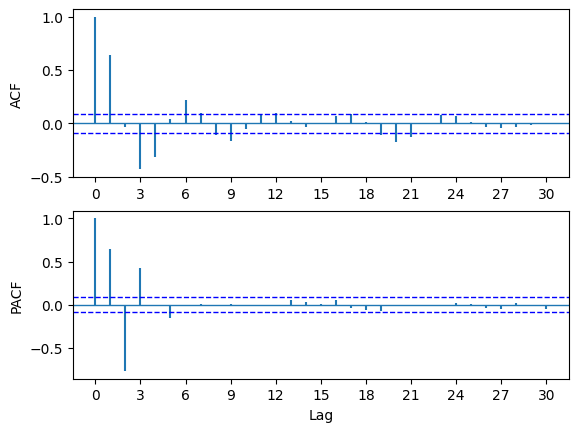

In [34]:
# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
acf_pacf_fig(x, both = True)

In [35]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(x)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -10.277213153299344
      p-value: 3.8625146882230924e-18

p-value < alpha; Ha: Stationary


In [36]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_stat, p_value, lags, critical_values = kpss(x, regression='c', nlags=50)

# Output the results
print(f"KPSS Test Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical values: {critical_values}")
print()

# Interpretation
if p_value < 0.05:
    print("p-value < 0.05; Ha: series is Non-stationary")
else:
    print("p-value > 0.05; H0: series is Stationary")

KPSS Test Statistic: 0.15383390266132616
P-value: 0.1
Lags used: 50
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

p-value > 0.05; H0: series is Stationary


In [37]:
# Choosing p & q
sm.tsa.arma_order_select_ic(x, max_ar=4, max_ma=4, ic='aic', trend='c')

{'aic':              0            1            2            3            4
 0  2237.411635  1786.592940  1560.245034  1492.294146  1494.179203
 1  1972.365180  1662.317191  1533.549434  1556.980726  1465.438206
 2  1523.491126  1443.291987  1410.894683  1409.692860  1411.095939
 3  1414.948231  1416.783710  1409.456404  1411.325006  1411.559187
 4  1416.673155  1417.769791  1410.666748  1411.575812  1413.273691,
 'aic_min_order': (3, 2)}

In [38]:
# Choosing p & q based on AIC
order_selection = sm.tsa.arma_order_select_ic(x, max_ar=4, max_ma=4, ic='aic', trend='c')

# Extract the AIC matrix from the result
aic_matrix = order_selection['aic']

# Create a list of (p, q) pairs and their corresponding AIC values
aic_list = []
for p in range(aic_matrix.shape[0]):
    for q in range(aic_matrix.shape[1]):
        aic_list.append(((p, q), aic_matrix.iloc[p, q]))

# Convert to DataFrame
aic_df = pd.DataFrame(aic_list, columns=['(p, q)', 'AIC'])

# Sort the DataFrame by AIC values in ascending order
aic_df_sorted = aic_df.sort_values(by='AIC').reset_index(drop=True)

# Display the sorted DataFrame
aic_df_sorted.head(10)

,"(p, q)",AIC
0,"(3, 2)",1409.456404
1,"(2, 3)",1409.692860
2,"(4, 2)",1410.666748
3,"(2, 2)",1410.894683
4,"(2, 4)",1411.095939
5,"(3, 3)",1411.325006
6,"(3, 4)",1411.559187
7,"(4, 3)",1411.575812
8,"(4, 4)",1413.273691
9,"(3, 0)",1414.948231


In [39]:
# Fit the ARIMA (3,0,2) model to our data
model302 = ARIMA(x, order=(3,0,2), trend='n').fit()

# Display the summary
model302.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -697.740
Date:                Fri, 07 Mar 2025   AIC                           1407.481
Time:                        08:23:51   BIC                           1432.768
Sample:                             0   HQIC                          1417.403
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1372      0.155      7.335      0.000       0.833       1.441
ar.L2         -0.9663      0.165     -5.871      0.000      -1.289      -0.644
ar.L3          0.2332      0.119      1.964      0.050       0.000       0.466
ma.L1          0.3560      0.155      2.293      0.022       0.052       0.660
ma.L2          0.2589      0.080      3.222      0.001       0.101       0.416
sigma2         0.9483      0.057     16.650      0.000       0.837       1.060
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.52
Prob(Q):                              0.92   Prob(JB):                         0.06
Heteroskedasticity (H):               1.21   Skew:                             0.19
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

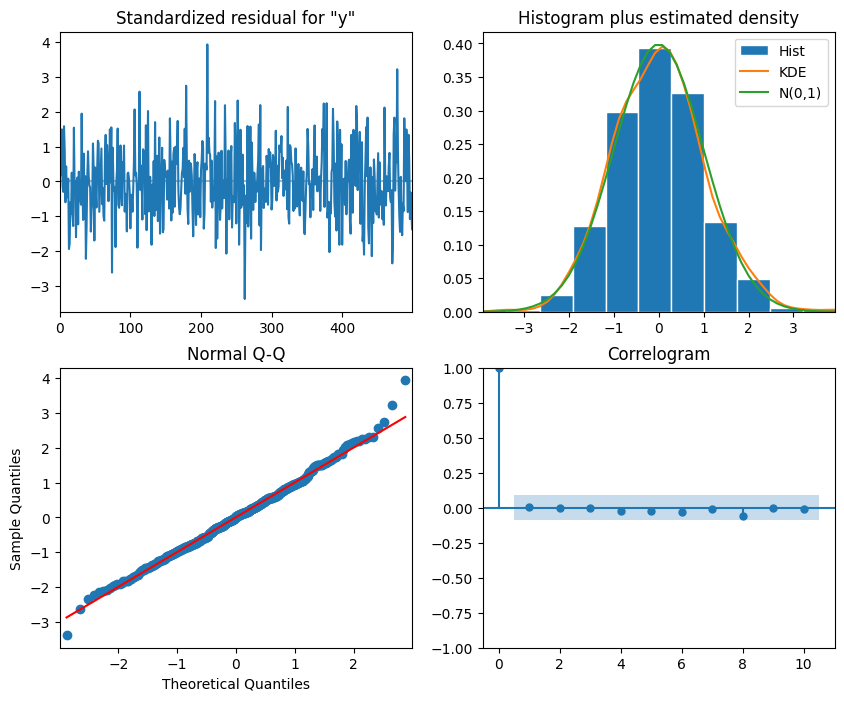

In [40]:
# Extract the residuals (errors) from the fitted model
residuals302 = model302.resid 

# Diagnostic plots for the model, including residuals and other model checks
model302.plot_diagnostics(figsize=(10,8));

In [41]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals302 = acorr_ljungbox(residuals302, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals302['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals302

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.012212,0.912008
2,0.012240,0.993898
3,0.018773,0.999320
4,0.230743,0.993835
5,0.525962,0.991142
6,0.944692,0.987622
7,0.964285,0.995384
8,2.608810,0.956464
9,2.609940,0.977779
10,2.689468,0.987818


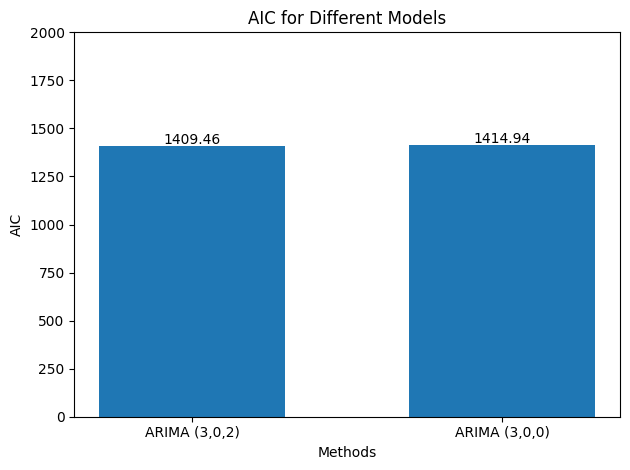

In [42]:
fig, ax = plt.subplots()

x = ['ARIMA (3,0,2)', 'ARIMA (3,0,0)']
y = [1409.46, 1414.94]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('AIC')
ax.set_title('AIC for Different Models')
ax.set_ylim(0, 2000)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 10, s=str(round(value, 2)), ha='center')

plt.tight_layout()

#### We get the time series dtepts in Example 4.3. Now use an ARMA(1,3) model to fit it, and then compare the fitted model with the estimated model ARMA(1,1) in Example 4.3.

In [44]:
glob =pd.read_csv(dtapath + 'Global mean surface air temp changes 1880-1985.csv', header= None)

glob

,0
0,-0.40
1,-0.37
2,-0.43
3,-0.47
4,-0.72
...,...
101,0.42
102,0.02
103,0.30
104,0.09


In [45]:
dates = pd.date_range('1880-12', periods = len(glob), freq = 'A-DEC')
glob.index = dates

glob.head()

,0
1880-12-31,-0.40
1881-12-31,-0.37
1882-12-31,-0.43
1883-12-31,-0.47
1884-12-31,-0.72


In [46]:
tepts = pd.Series(glob[0], name = 'tep')
tepts

1880-12-31   -0.40
1881-12-31   -0.37
1882-12-31   -0.43
1883-12-31   -0.47
1884-12-31   -0.72
              ... 
1981-12-31    0.42
1982-12-31    0.02
1983-12-31    0.30
1984-12-31    0.09
1985-12-31    0.05
Freq: YE-DEC, Name: tep, Length: 106, dtype: float64

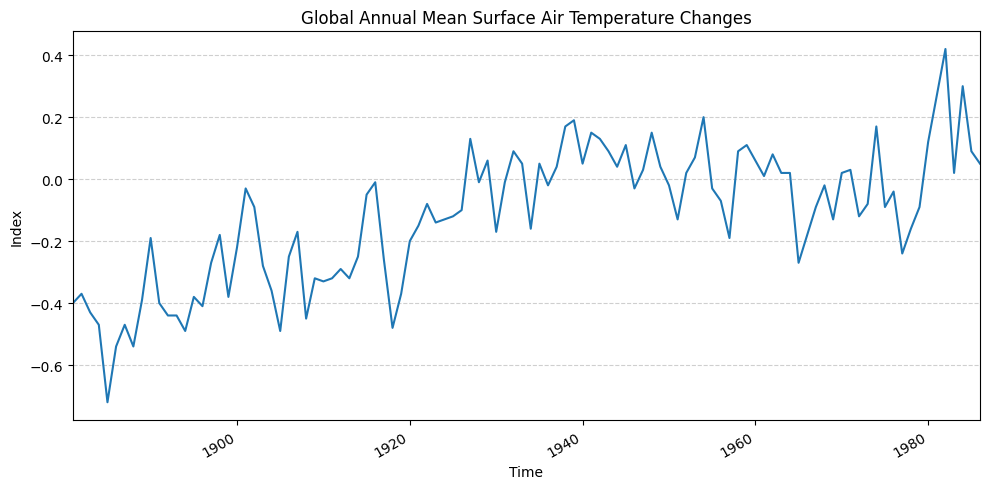

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(tepts)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('Global Annual Mean Surface Air Temperature Changes')
ax.set_xlim(pd.to_datetime('1880-12-31'), pd.to_datetime('1985-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)

fig.autofmt_xdate()
plt.tight_layout()

In [48]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(tepts)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.9091315185935533
      p-value: 0.32777762531437676

p-value > alpha; H0: Not Stationary


In [49]:
# First-Order differencing
eps_diff = np.diff(tepts, n=1)

ad_fuller_result1 = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -6.437287387132181
p-value: 1.6408522350646174e-08

p-value < alpha; Ha: Stationary


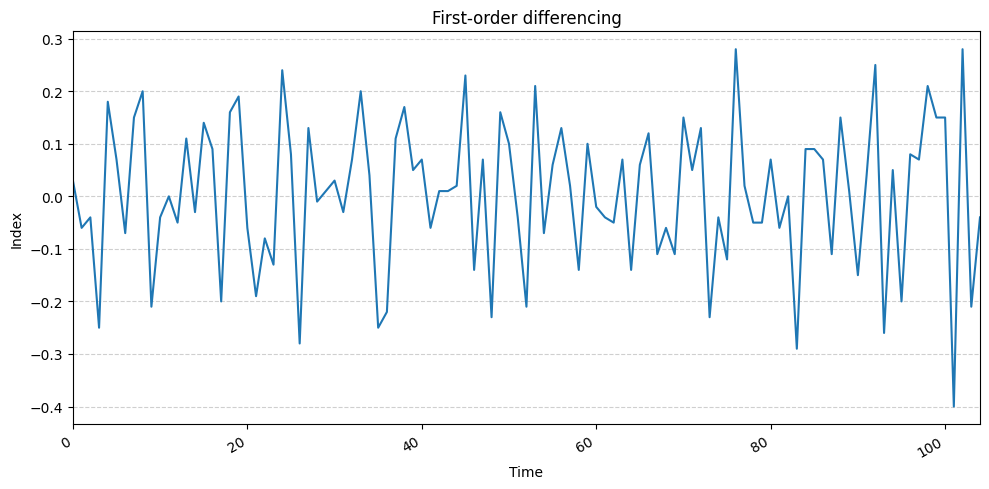

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(eps_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('First-order differencing')
ax.set_xlim(0,104)
ax.grid(axis='y', linestyle='--', alpha=0.6)

fig.autofmt_xdate()
plt.tight_layout()

In [51]:
# Choosing p & q based on AIC
order_selection = sm.tsa.arma_order_select_ic(eps_diff, max_ar=4, max_ma=4, ic='aic', trend='c')

# Extract the AIC matrix from the result
aic_matrix = order_selection['aic']

# Create a list of (p, q) pairs and their corresponding AIC values
aic_list = []
for p in range(aic_matrix.shape[0]):
    for q in range(aic_matrix.shape[1]):
        aic_list.append(((p, q), aic_matrix.iloc[p, q]))

# Convert to DataFrame
aic_df = pd.DataFrame(aic_list, columns=['(p, q)', 'AIC'])

# Sort the DataFrame by AIC values in ascending order
aic_df_sorted = aic_df.sort_values(by='AIC').reset_index(drop=True)

# Display the sorted DataFrame
aic_df_sorted.head(10)

,"(p, q)",AIC
0,"(1, 3)",-135.557685
1,"(1, 4)",-132.998116
2,"(2, 4)",-131.664024
3,"(1, 1)",-130.712747
4,"(0, 2)",-129.955769
5,"(0, 3)",-129.737782
6,"(2, 2)",-129.443017
7,"(2, 1)",-129.249741
8,"(3, 1)",-128.652887
9,"(3, 3)",-128.466331


In [52]:
# Split the data into training and test sets
train_size = int(len(eps_diff) * 0.8)                                  # 80% of data for training
train_data, test_data = eps_diff[:train_size], eps_diff[train_size:]   # 20% data for test

In [53]:
print(len(train_data))
print(len(test_data))

84
21


In [54]:
# Fit the ARIMA (1,1,3) model to our data
model113 = ARIMA(train_data, order=(1,1,3), trend='n').fit()

# Display the summary
model113.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   84
Model:                 ARIMA(1, 1, 3)   Log Likelihood                  51.740
Date:                Fri, 07 Mar 2025   AIC                            -93.479
Time:                        08:24:06   BIC                            -81.385
Sample:                             0   HQIC                           -88.620
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9414      0.131     -7.181      0.000      -1.198      -0.684
ma.L1         -0.6820      6.450     -0.106      0.916     -13.323      11.959
ma.L2         -0.9977      3.478     -0.287      0.774      -7.815       5.819
ma.L3          0.6799      5.053      0.135      0.893      -9.223      10.583
sigma2         0.0152      0.114      0.134      0.893      -0.207       0.238
===================================================================================
Ljung-Box (L1) (Q):                   3.38   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.07   Prob(JB):                         0.48
Heteroskedasticity (H):               0.75   Skew:                            -0.31
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

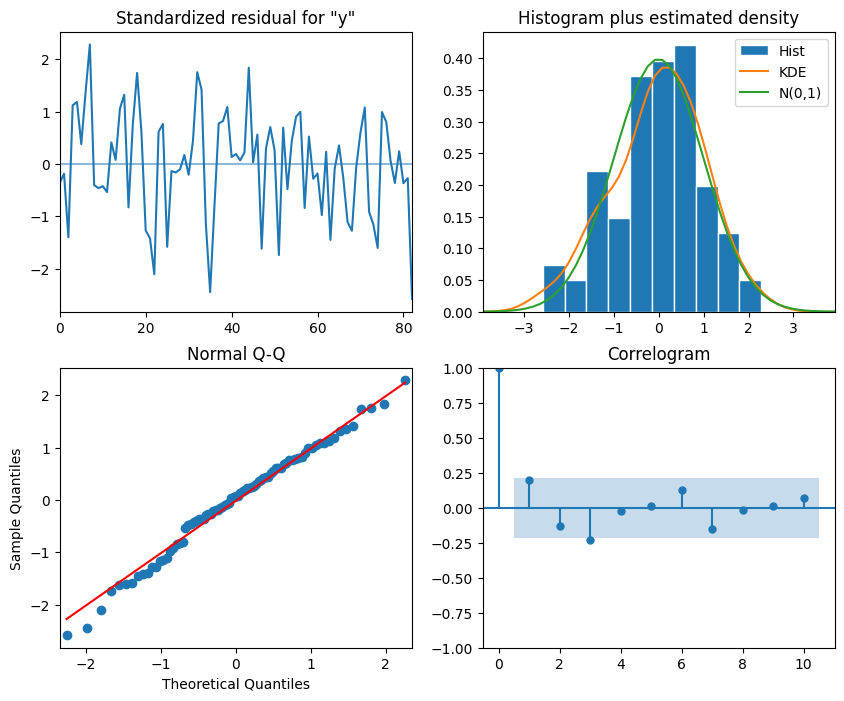

In [55]:
# Extract the residuals (errors) from the fitted model
residuals113 = model113.resid 

# Diagnostic plots for the model, including residuals and other model checks
model113.plot_diagnostics(figsize=(10,8));

In [56]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals113 = acorr_ljungbox(residuals113, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals113['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals113

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,3.347652,0.067301
2,4.646936,0.097933
3,9.058688,0.028521
4,9.142430,0.057636
5,9.155952,0.103003
6,10.199858,0.116484
7,12.310319,0.090805
8,12.310532,0.137877
9,12.355822,0.193985
10,12.781529,0.236145


In [57]:
# Construction of 'test_zone'

# Create an empty dataframe
test_zone = pd.DataFrame()

# Original Data created based on the end of the original dataset
test_zone['original data'] = tepts.iloc[-len(test_data):]

test_zone.head()

,original data
1965-12-31,-0.18
1966-12-31,-0.09
1967-12-31,-0.02
1968-12-31,-0.13
1969-12-31,0.02


In [58]:
# Forecast for the differenced data (eps_diff)
forecast_diff = model113.forecast(steps=len(test_data)) 

# Inverse differencing (adding back the previous value to get the forecast for 'tepts')
forecast_tepts = np.cumsum(forecast_diff) + tepts[-len(test_data):] 

test_zone['forecast_tepts'] = forecast_tepts
test_zone['difference'] = test_zone['forecast_tepts'] - test_zone['original data']

test_zone.head()

,original data,forecast_tepts,difference
1965-12-31,-0.18,0.023208,0.203208
1966-12-31,-0.09,0.145294,0.235294
1967-12-31,-0.02,0.194093,0.214093
1968-12-31,-0.13,0.113056,0.243056
1969-12-31,0.02,0.244795,0.224795


In [59]:
test_zone['difference'].mean()

0.2632845295761878

In [60]:
test_zone['correction'] = test_zone['forecast_tepts'] - 0.2632845295761878

test_zone.head()

,original data,forecast_tepts,difference,correction
1965-12-31,-0.18,0.023208,0.203208,-0.240076
1966-12-31,-0.09,0.145294,0.235294,-0.117991
1967-12-31,-0.02,0.194093,0.214093,-0.069192
1968-12-31,-0.13,0.113056,0.243056,-0.150228
1969-12-31,0.02,0.244795,0.224795,-0.018490


In [61]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_zone['original data'], test_zone['correction'])
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.025263324761091308


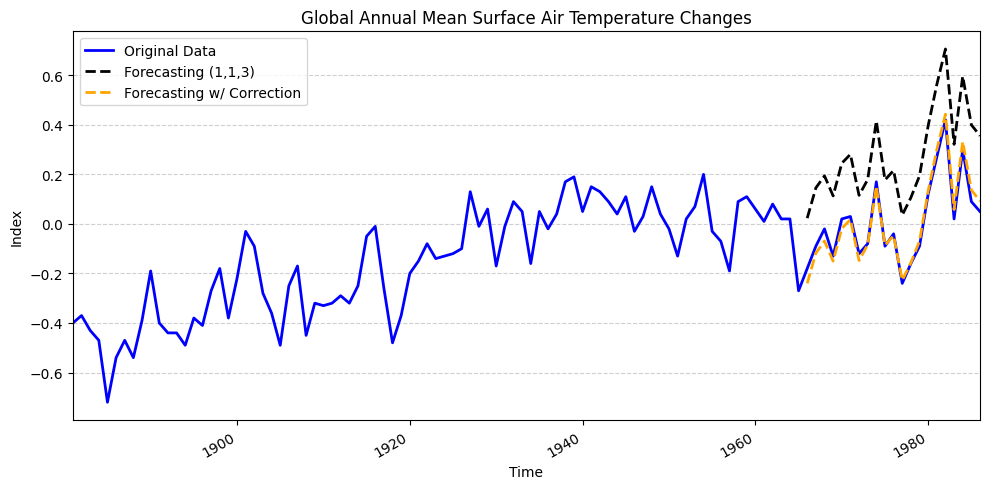

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(tepts, color='blue', label='Original Data', linewidth=2)
ax.plot(test_zone['forecast_tepts'], linestyle='--', color='black', label='Forecasting (1,1,3)', linewidth=2)
ax.plot(test_zone['correction'], linestyle='--', color='orange', label='Forecasting w/ Correction', linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('Global Annual Mean Surface Air Temperature Changes')
ax.set_xlim(pd.to_datetime('1880-12-31'), pd.to_datetime('1985-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

#### Use models ARIMA(6,1,7), ARIMA(0,1,1), and ARIMA(0,1,6), respectively, to fit the data ly in Example 4.4. Are they appropriate models? Why?

In [64]:
usbill = pd.read_csv(dtapath + "USbill.csv", header = None)
usbill.head()

,0,1
0,1950/1/31,1.07
1,1950/2/28,1.12
2,1950/3/31,1.12
3,1950/4/30,1.25
4,1950/5/31,1.16


In [65]:
usbill.rename(columns={0: 'time', 1: 'bill'}, inplace=True)
usbill.head()

,time,bill
0,1950/1/31,1.07
1,1950/2/28,1.12
2,1950/3/31,1.12
3,1950/4/30,1.25
4,1950/5/31,1.16


In [66]:
usbill['time'] = pd.to_datetime(usbill['time'], format='%Y/%m/%d')  # Convert to datetime
usbill.set_index('time', inplace=True)                              # Set 'time' column as the index

usbill.head()

,bill
time,
1950-01-31,1.07
1950-02-28,1.12
1950-03-31,1.12
1950-04-30,1.25
1950-05-31,1.16


In [67]:
usbill.tail()

,bill
time,
1988-02-29,5.66
1988-03-31,5.70
1988-04-30,5.91
1988-05-31,6.26
1988-06-30,6.46


In [68]:
usbill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 1950-01-31 to 1988-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bill    462 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


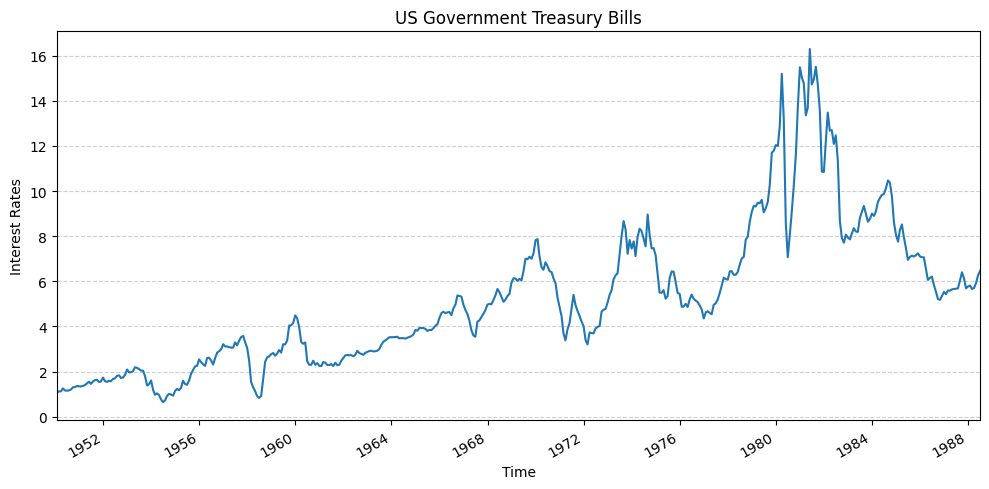

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(usbill)
ax.set_xlabel('Time')
ax.set_ylabel('Interest Rates')
ax.set_title('US Government Treasury Bills')
ax.set_xlim(pd.to_datetime('1950-01-31'), pd.to_datetime('1988-06-30	'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()

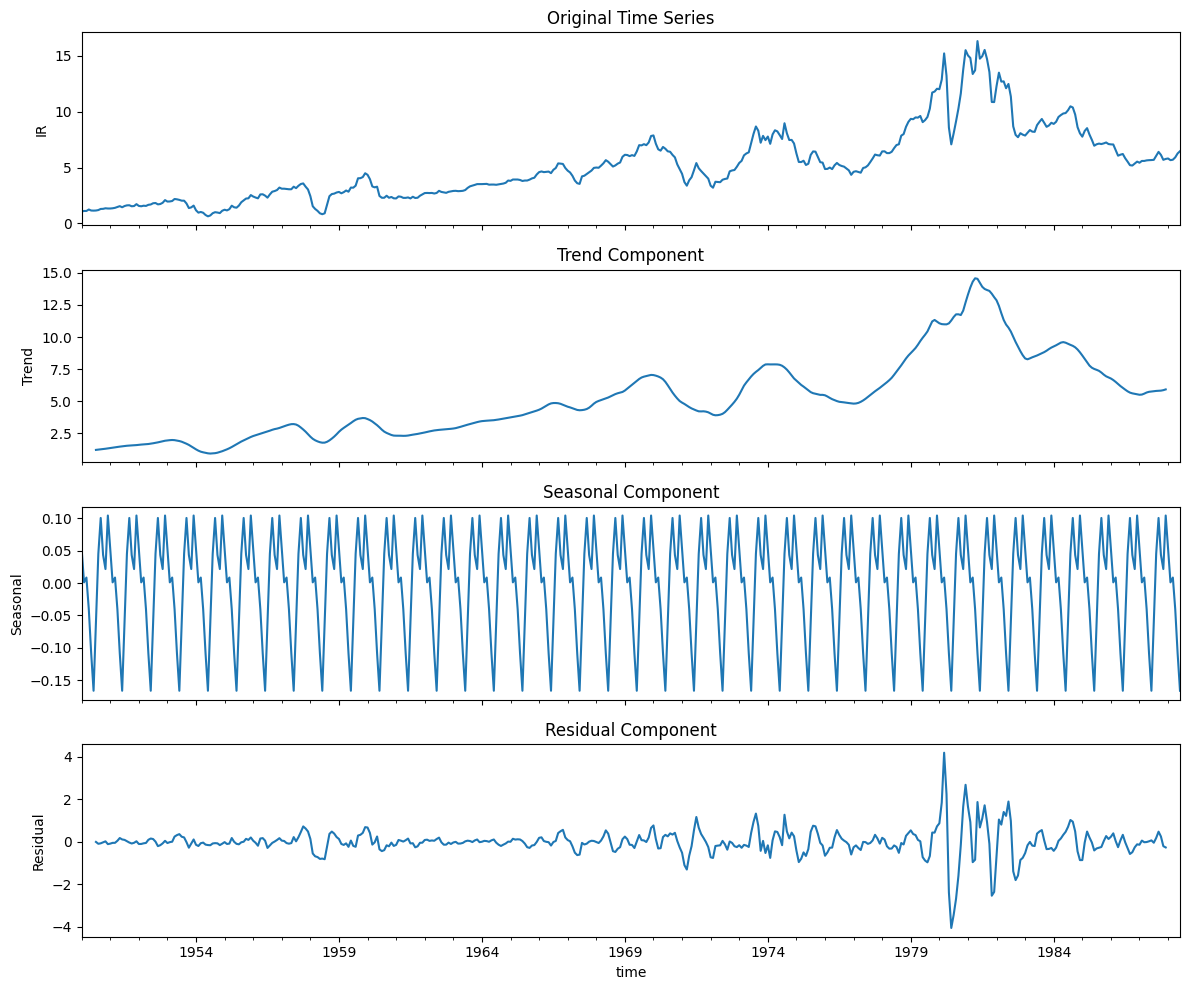

In [70]:
# Perform seasonal decomposition
bill_decom = seasonal_decompose(usbill, model='aditive')  # quarterly data, so period = 4

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

bill_decom.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('IR')

bill_decom.trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

bill_decom.seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

bill_decom.resid.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [71]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(usbill['bill'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.104007146187352
      p-value: 0.2429063638026972

p-value > alpha; H0: Not Stationary


In [72]:
# First-Order differencing
eps_diff = np.diff(usbill['bill'], n=1)

ad_fuller_result1 = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -4.643808090288343
p-value: 0.0001071698151690653

p-value < alpha; Ha: Stationary


In [73]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_stat, p_value, lags, critical_values = kpss(eps_diff, regression='ct', nlags=50)  # ct, because there is a trend

# Output the results
print(f"KPSS Test Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical values: {critical_values}")
print()

# Interpretation
if p_value < 0.05:
    print("p-value < 0.05; Ha: series is Non-stationary")
else:
    print("p-value > 0.05; H0: series is Stationary")

KPSS Test Statistic: 0.06450672639955289
P-value: 0.1
Lags used: 50
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

p-value > 0.05; H0: series is Stationary


In [74]:
# Split the data into training and test sets (80% for training, 20% for testing)
train_size = int(len(eps_diff) * 0.8)
train_data, test_data = eps_diff[:train_size], usbill[train_size:]

print(len(train_data))
print(len(test_data))

368
94


In [75]:
# Choosing p & q based on AIC
order_selection = sm.tsa.arma_order_select_ic(train_data, max_ar=4, max_ma=4, ic='aic', trend='c') # c, because there is a trend

# Extract the AIC matrix from the result
aic_matrix = order_selection['aic']

# Create a list of (p, q) pairs and their corresponding AIC values
aic_list = []
for p in range(aic_matrix.shape[0]):
    for q in range(aic_matrix.shape[1]):
        aic_list.append(((p, q), aic_matrix.iloc[p, q]))

# Convert to DataFrame
aic_df = pd.DataFrame(aic_list, columns=['(p, q)', 'AIC'])

# Sort the DataFrame by AIC values in ascending order
aic_df_sorted = aic_df.sort_values(by='AIC').reset_index(drop=True)

# Display the sorted DataFrame
aic_df_sorted.head(10)

,"(p, q)",AIC
0,"(3, 4)",359.854784
1,"(3, 1)",360.197986
2,"(4, 4)",360.468350
3,"(1, 2)",362.944003
4,"(3, 3)",363.599250
5,"(4, 2)",363.695165
6,"(2, 0)",364.494664
7,"(4, 3)",365.047270
8,"(0, 4)",365.111580
9,"(2, 4)",365.219505


In [76]:
# Choosing p & q
sm.tsa.arma_order_select_ic(train_data, max_ar=7, max_ma=7, ic='aic', trend='c')

{'aic':             0           1           2           3           4           5  \
 0  440.019818  373.508115  374.280153  369.955662  365.111580  366.133615   
 1  398.568178  374.816104  362.944003  368.067935  366.222804  368.115981   
 2  364.494664  366.402264  367.944788  369.795625  365.219505  366.729885   
 3  366.406025  360.197986  368.954799  363.599250  359.854784  363.856012   
 4  368.387064  368.736177  363.695165  365.047270  360.468350  363.157129   
 5  370.299455  369.943065  371.620348  365.582543  362.525985  361.883778   
 6  364.295034  364.824143  360.293058  367.111188  362.529808  359.109339   
 7  365.024221  366.690435  368.701589  364.014042  365.411940  363.376543   
 
             6           7  
 0  368.059429  366.870364  
 1  369.224772  367.572823  
 2  357.799721  359.521229  
 3  359.637146  360.964621  
 4  357.333250  363.573548  
 5  358.793310  360.929610  
 6  360.912134  362.799022  
 7  362.748519  362.919009  ,
 'aic_min_order': (4, 6)}

| Model| AIC |
|:--------:|:--------:|
| ARIMA(6,1,7)    | 364.824143    | 
| ARIMA(0,1,1)    | 373.508115    | 
| ARIMA(0,1,6)    | 368.059429    | 
| ARIMA(4,1,6)    | 357.333250    |